[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vietanhdev/tien-giay-vn/blob/master/train.ipynb)

# Phân loại tiền giấy Việt Nam

Notebook này nhằm viết lại bài viết **Nhận dạng tiền Việt Nam với Transfer Learning (VGG16 CNN Classify)** của Mì AI nhằm thay bằng mạng phân loại nhỏ hơn và chuyển đổi qua ONNX để sử dụng với OpenCV DNN.

- Link bài viết: <https://www.miai.vn/2020/04/21/nhan-dang-tien-viet-nam-voi-transfer-learning-vgg16-cnn-classify/>
- Dữ liệu lấy từ Blog Mì AI.

Cảm ơn admin với bài viết rất tâm huyết. Mình viết notebook này nhằm đóng góp thêm cho cộng đồng. Anh em có thể thả **star** tại <https://github.com/vietanhdev/tien-giay-vn>. Thanks :D 

Anh em có thể cải thiện độ chính xác bằng cách thu thêm dữ liệu với nhiều điều kiện hơn nữa, đặc biệt với class không phải tiền (00000).


In [1]:
# Khai báo thư viện Tensorflow
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
# Khai báo các thư viện cần thiết khác
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import glob
import time
import cv2
import os

**Các siêu tham số:**

In [3]:
num_epochs = 10 # Số lượng lần huấn luyện đi qua hết 1 vòng tập dữ liệu
learning_rate = 0.001 # Tỷ lệ học của thuật toán
batch_size = 64

## I. Chuẩn bị dữ liệu

Các lớp đối tượng gồm có: 

+ /00000: Không phải tiền
+ /10000
+ /20000
+ /50000

Bộ dữ liệu được chuẩn bị bởi Admin Mì AI: <https://www.miai.vn/thu-vien-mi-ai/>

### Tải dữ liệu

In [4]:
# Xóa dữ liệu cũ
!rm -rf /content/data
!rm -rf /content/data_raw

In [5]:
# Tải và giải nén dữ liệu
!mkdir /content/data_raw
%cd /content/data_raw
!gdown https://drive.google.com/uc?id=1iGkllh1Az1mW6WMU5ZJiZwg1AVUu9fO4
!unzip -qo tien_vn.zip

/content/data_raw
Downloading...
From: https://drive.google.com/uc?id=1iGkllh1Az1mW6WMU5ZJiZwg1AVUu9fO4
To: /content/data_raw/tien_vn.zip
100% 1.09G/1.09G [00:05<00:00, 204MB/s]


In [6]:
%cd /content/data_raw
all_img_paths = list(paths.list_images("."))
print(all_img_paths[:10])

/content/data_raw
['./10000/329.png', './10000/473.png', './10000/672.png', './10000/715.png', './10000/491.png', './10000/364.png', './10000/512.png', './10000/152.png', './10000/180.png', './10000/730.png']


### Trộn dữ liệu và hiện ảnh

In [7]:
# Trộn dữ liệu và hiện các hình ảnh
np.random.seed(0)
random.shuffle(all_img_paths)
print(all_img_paths[:5])

['./10000/369.png', './10000/670.png', './00000/320.png', './10000/918.png', './10000/154.png']


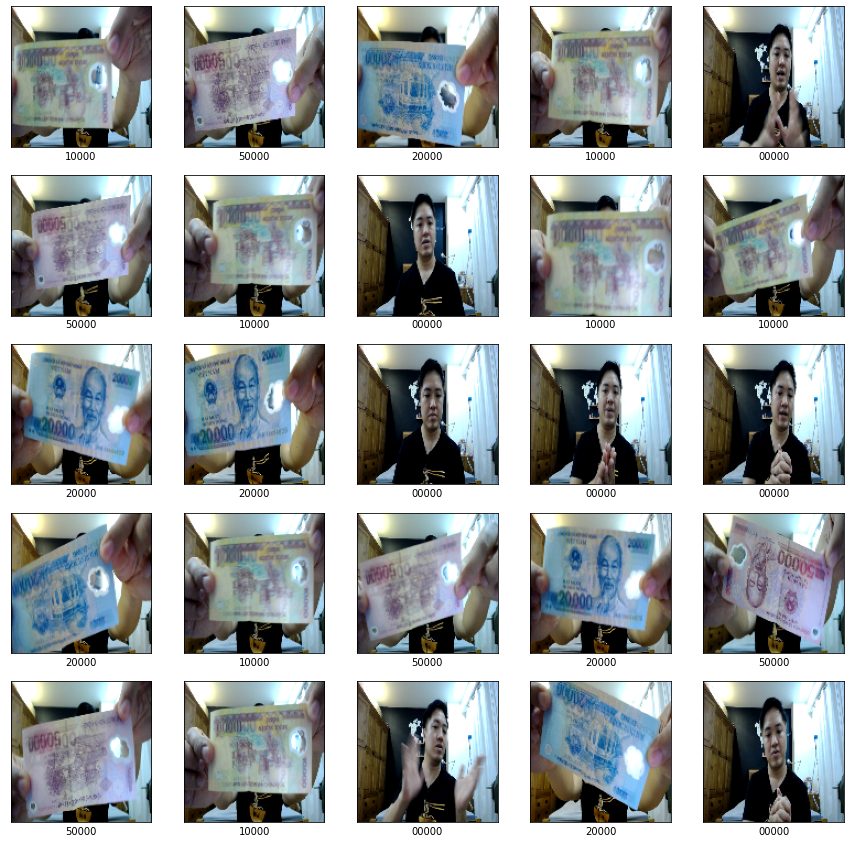

In [8]:
# Visualize images
plt.figure(figsize=(15,15))
for i in range(25):
    image_path = np.random.choice(all_img_paths)
    image = plt.imread(image_path)
    image = cv2.resize(image, (128, 128))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

### Chia dữ liệu

Thông thường, với bài toán huấn luyện mô hình trí tuệ nhân tạo, chúng ta thường chia dữ liệu làm 3 tập (tập huấn luyện, tập giám sát, và tập kiểm tra), hoặc 2 tập (tập huấn luyện và tập giám sát).

Để đơn giản, chúng tôi chia dữ liệu chỉ thành hai tập con: tập huấn luyện - training set (70%) và tập giám sát - validation set (30%).

Sau khi tách, cấu trúc tập dữ liệu của chúng ta sẽ giống như sau:

```
/content
    + /train
        + /00000: Không phải tiền
        + /10000
        + /20000
        + /50000
    + /val
        + /00000: Không phải tiền
        + /10000
        + /20000
        + /50000
```


In [9]:
!rm -rf /content/data/

In [10]:
val_ratio = 0.30
train_dir = "/content/data/train"
val_dir = "/content/data/val"

In [11]:
val_imgs = int(len(all_img_paths) * val_ratio)
train_imgs = len(all_img_paths) - val_imgs
train_img_paths = all_img_paths[:train_imgs]
val_img_paths = all_img_paths[train_imgs:]

In [12]:
# Function for copying images into subset folder
def copy_images(img_paths, output_dir):
	for imagePath in img_paths:
		# extract the label from the current image path
		label = imagePath.split("/")[1]

		# check if a directory for the label exists, if not, create it
		imageDir = os.path.join(output_dir, label)
		if not os.path.exists(imageDir):
			os.makedirs(imageDir)

		# copy the current image to the respective folder
		shutil.copy2(imagePath, imageDir)

In [13]:
copy_images(train_img_paths, train_dir)
copy_images(val_img_paths, val_dir)

### Chuẩn bị trình sinh dữ liệu

Chúng tôi sẽ sử dụng Keras `ImageDataGenerator` để cung cấp dữ liệu huấn luyện. Hình ảnh sẽ được tải tự động bởi trình tạo, được biến đổi bằng các phương pháp tăng cường ảnh và thay đổi kích thước bằng kích thước của đầu vào mô hình (224, 224).


In [14]:
# Switch to /content/data
%cd /content/data

/content/data


In [15]:
# Setup data generators
train_aug = ImageDataGenerator(rescale=1/255.,
								rotation_range=20,
								zoom_range=0.1,
								width_shift_range=0.1,
								height_shift_range=0.1,
								horizontal_flip=True,
								brightness_range=[0.2, 1.5], fill_mode="nearest")

val_aug = ImageDataGenerator(rescale=1/255.)

print("Training set")
train_gen = train_aug.flow_from_directory(train_dir,
    class_mode="categorical",
    target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=batch_size
)

print("Validation set")
val_gen = train_aug.flow_from_directory(val_dir,
    class_mode="categorical",
    target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=batch_size
)
num_classes = len(train_gen.class_indices.keys())
print("Set number of classes to {}".format(num_classes))

Training set
Found 2803 images belonging to 4 classes.
Validation set
Found 1201 images belonging to 4 classes.
Set number of classes to 4


In [16]:
# Get the class labels and export to labels.txt
print(train_gen.class_indices)
labels = '\n'.join(sorted(train_gen.class_indices.keys()))
with open('labels.txt', 'w') as f:
    f.write(labels)

{'00000': 0, '10000': 1, '20000': 2, '50000': 3}


In [17]:
# Save number of training and validation samples to use later
num_train_samples = len(list(paths.list_images("train")))
num_val_samples = len(list(paths.list_images("val")))
print("Train: {} images, Val: {} images".format(num_train_samples, num_val_samples))

Train: 2803 images, Val: 1201 images


## II. Huấn luyện

Trong phần này, chúng tôi xây dựng và đào tạo mô hình phân loại ảnh dựa trên dữ liệu đã chuẩn bị. Hàm `build_model` bên dưới giúp chúng ta chuẩn bị mô hình. Chúng tôi sử dụng LeNet làm xương sống để trích xuất các đặc trưng ảnh, sau đó đính kèm một lớp `GlobalAveragePooling2D()` và một số lớp fully connected hơn để phân loại.


In [18]:
# Switch to /content
%cd /content

/content


In [19]:
def build_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, alpha=0.35)
    base_model.trainable = False
    classifier = Sequential()
    classifier.add(base_model)
    classifier.add(GlobalAveragePooling2D())
    classifier.add(Dropout(0.5))
    classifier.add(Dense(128, activation='relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(64, activation='relu'))
    classifier.add(Dense(num_classes, activation='softmax'))
    classifier.compile(loss="categorical_crossentropy", 
                          optimizer=tf.keras.optimizers.Adam(learning_rate),
                          metrics=["accuracy"])
    return classifier

Chúng ta thực hiện huấn luyện mô hình theo các tham số đã cài đặt trước:

In [20]:
# Build model
classification_model = build_model()

# Setup a callback to save the best model
best_model_path = "best_model_checkpoint.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

start = time.time()
history = classification_model.fit(train_gen,
    steps_per_epoch=num_train_samples // batch_size,
    validation_data=val_gen,
    validation_steps=num_val_samples // batch_size,
    epochs=num_epochs,
    callbacks=[model_checkpoint_callback]
)
print("Total training time: ", time.time()-start)

# Load the best model weights
classification_model.load_weights(best_model_path)

Epoch 1/10
43/43 [==============================] - 68s 1s/step - loss: 0.8609 - accuracy: 0.6313 - val_loss: 0.3083 - val_accuracy: 0.9123
Epoch 2/10
43/43 [==============================] - 64s 2s/step - loss: 0.4714 - accuracy: 0.8109 - val_loss: 0.2208 - val_accuracy: 0.9210
Epoch 3/10
43/43 [==============================] - 64s 1s/step - loss: 0.3488 - accuracy: 0.8554 - val_loss: 0.1583 - val_accuracy: 0.9453
Epoch 4/10
43/43 [==============================] - 63s 1s/step - loss: 0.2932 - accuracy: 0.8872 - val_loss: 0.1385 - val_accuracy: 0.9523
Epoch 5/10
43/43 [==============================] - 63s 1s/step - loss: 0.2566 - accuracy: 0.8927 - val_loss: 0.1134 - val_accuracy: 0.9661
Epoch 6/10
43/43 [==============================] - 63s 1s/step - loss: 0.2474 - accuracy: 0.9065 - val_loss: 0.1165 - val_accuracy: 0.9679
Epoch 7/10
43/43 [==============================] - 63s 1s/step - loss: 0.2390 - accuracy: 0.9043 - val_loss: 0.1053 - val_accuracy: 0.9566
Epoch 8/10
43/43 [==

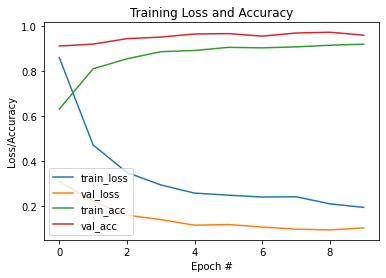

In [21]:
# Plot training graph
N = len(history.history["loss"])
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [22]:
eval_result = classification_model.evaluate(val_gen)
val_accuracy = eval_result[1]
print("Model accuracy on validation set: {}".format(val_accuracy))

19/19 [==============================] - 19s 994ms/step - loss: 0.0927 - accuracy: 0.9675
Model accuracy on validation set: 0.9675270318984985


## III. Chuyển đổi mô hình.

Để có một mô hình có thể được sử dụng với OpenCV DNN, chúng tôi chuyển đổi mô hình được đào tạo thành [định dạng ONNX](https://onnx.ai/).

In [23]:
!pip install -U tf2onnx

In [24]:
import onnx
import tf2onnx

onnx_model, _ = tf2onnx.convert.from_keras(classification_model, opset=11, output_path="classifier.onnx")
output_names = [n.name for n in onnx_model.graph.output]
print("Output names: ", output_names)

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
Output names:  ['dense_2']


Bây giờ bạn có thể nhìn vào thanh bên trái, mở trình duyệt tệp và tải xuống mô hình `classifier.onnx`.